 # Data Loader

In [87]:
# Read tiff
from tifffile import TiffFile
import numpy as np

class TiffReader:
    def __init__(self, filename):
        self.filename = filename
        self.tiff_file = TiffFile(filename)

    def read_image(self, index=0):
        """Read an image from the TIFF file at the specified index."""
        if index < 0 or index >= len(self.tiff_file.pages):
            raise IndexError("Index out of range for TIFF pages.")
        return self.tiff_file.pages[index].asarray()
    
    def len(self):
        """Return the number of images in the TIFF file."""
        return len(self.tiff_file.pages)

    def close(self):
        """Close the TIFF file."""
        self.tiff_file.close()
        

In [88]:
# Read png
import cv2

class PngReader:
    def __init__(self, path):
        self.path = path

    def read_image(self, index=0):
        """Read a PNG image from the specified path."""

        file_name = f"{self.path}/depth{index:05d}.png"

        return cv2.imread(file_name, cv2.IMREAD_UNCHANGED)
    
    def len(self):
        """Return the number of images in the PNG sequence."""
        # Assuming the PNG files are named in a sequential MAnner
        import os
        files = [f for f in os.listdir(self.path) if f.startswith('depth') and f.endswith('.png')]
        return len(files)
    
    def close(self):
        """Close the PNG reader."""
        # No specific close operation needed for PNG files
        pass


 # Motion Artifact Removal

In [89]:
import cupy as cp
import cv2

class MotionArtifactRemover:
    def __init__(self, window_size=5, batch_size=2, alpha=20, fps=30):
        """
        Initialize the MotionArtifactRemover with parameters for window size, batch size, alpha, and fps.
        """
        self.window_frames = window_size * fps
        self.batch_frames = batch_size * fps
        self.alpha = alpha
        self.frames = []
        self.frame_number = 0
        self.poped_frames = 0

    def process_frame(self, frame):
        """
        Process a single frame to remove motion artifacts.
        """
        frame = cp.asarray(frame)  # Convert to CuPy array for GPU processing

        self.frames.append(frame)
        self.frame_number += 1

        # MAintain a sliding window of frames
        if len(self.frames) > self.window_frames:
            self.frames.pop(0)
            self.poped_frames += 1

        H, W = frame.shape
        MA = cp.zeros((H, W))  # Store averaged depth images
        F = cp.ones((H, W))  # Store validity flags

        # Template MAtching
        template_index = int(self.batch_frames * cp.floor((self.frame_number - 1) / self.batch_frames) - self.poped_frames)
        # print(f"Processing frame {self.frame_number}, template index: {template_index}")
        variation = cp.abs(self.frames[-1] - self.frames[template_index])

        # Filter out zeros from the variation array
        non_zero_variation = variation[variation != 0]
        # print(f"Non-zero variation count: {non_zero_variation.size}")

        # Compute the median of non-zero values
        if non_zero_variation.size == 0:
            median_variation = 0
        else:
            median_variation = cp.median(non_zero_variation)    

        # median_variation = cp.median(variation) 
        # print(f"Median variation: {median_variation}")

        # Outlier detection
        outliers = variation > self.alpha * median_variation
        F[outliers] = 0

        # Sliding window averaging
        MA = cp.mean(cp.stack(self.frames), axis=0)

        # Motion artifact removal
        processed_frame = (self.frames[-1] - MA) * F
        return processed_frame.get(), F.get(), MA.get()  # Move results back to CPU


In [90]:
import matplotlib.pyplot as plt


In [91]:
def plot_depth_map(data_loader, key_points=None):
    num_frames = data_loader.len()
    i = num_frames // 2  # Middle frame for visualization

    # Plot the first frame for debugging
    plt.get_current_fig_MAnager().set_window_title(f"Original Frame {i}")
    for j in range(len(key_points)):
        plt.plot(key_points[j][0], key_points[j][1], 'o', markersize=5, label=f'X={key_points[j][0]}, Y={key_points[j][1]}')
    
    plt.imshow(data_loader.read_image(i), cmap='gray')
    plt.title(f"Original Frame {i}")
    plt.show()

In [92]:
def process_depth_frames(data_loader, key_points, window_size=20, batch_size=5, fps=3):
    """
    Process depth frames from a TIFF file and visualize keypoint data.
    """
    default_fps = 30
    drop_rate = default_fps // fps
    num_frames = data_loader.len() // drop_rate

    # Initialize the artifact remover
    artifact_remover = MotionArtifactRemover(window_size=window_size, batch_size=batch_size, fps=fps)

    # Initialize lists for keypoint data
    key_data_raw = [[] for _ in range(len(key_points))]
    key_data_processed = [[] for _ in range(len(key_points))]

    # Process each frame in the TIFF file
    for i in range(num_frames):
        frame = data_loader.read_image(i * drop_rate)
        # Process the frame
        processed_frame, flag, ma = artifact_remover.process_frame(frame)

        # Store keypoint data
        for j, (x, y) in enumerate(key_points):
            if i < num_frames:
                key_data_raw[j].append(frame[y, x])  # Store raw keypoint data
                key_data_processed[j].append(processed_frame[y, x])  # Store processed keypoint data

        # Display original and processed frames
        cv2.imshow('Original Frame', frame.astype('uint8'))

        if flag is not None and ma is not None:
            cv2.imshow('Flag Frame', (flag * 255).astype('uint8'))
            cv2.imshow('MA Frame', ma.astype('uint8'))

        cv2.imshow('Processed Frame', processed_frame.astype('uint8'))

        if cv2.waitKey(1) & 0xff == ord('q'):
            break

    # Release resources
    cv2.destroyAllWindows()

    # Plot keypoint data
    i = num_frames // 2
    plt.figure(figsize=(15, 5))

    # Plot original frame with keypoints
    plt.subplot(1, 3, 1)
    plt.imshow(data_loader.read_image(i), cmap='gray')
    for j in range(len(key_points)):
        plt.plot(key_points[j][0], key_points[j][1], 'o', markersize=5, label=f'X={key_points[j][0]}, Y={key_points[j][1]}')
    plt.title(f'Original Frame {i}')
    plt.legend()

    # Plot raw keypoint data
    plt.subplot(1, 3, 2)
    for j in range(len(key_points)):
        plt.plot(key_data_raw[j], label=f'X={key_points[j][0]}, Y={key_points[j][1]}', alpha=0.7)
    plt.title('Keypoint Raw Data')
    plt.xlabel('Frame Number')
    plt.ylabel('Depth Value')
    plt.legend()

    # Plot processed keypoint data
    plt.subplot(1, 3, 3)
    for j in range(len(key_points)):
        plt.plot(key_data_processed[j], label=f'X={key_points[j][0]}, Y={key_points[j][1]}', alpha=0.7)
    plt.title('Keypoint Processed Data')
    plt.xlabel('Frame Number')
    plt.ylabel('Depth Value')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Test on different datasets

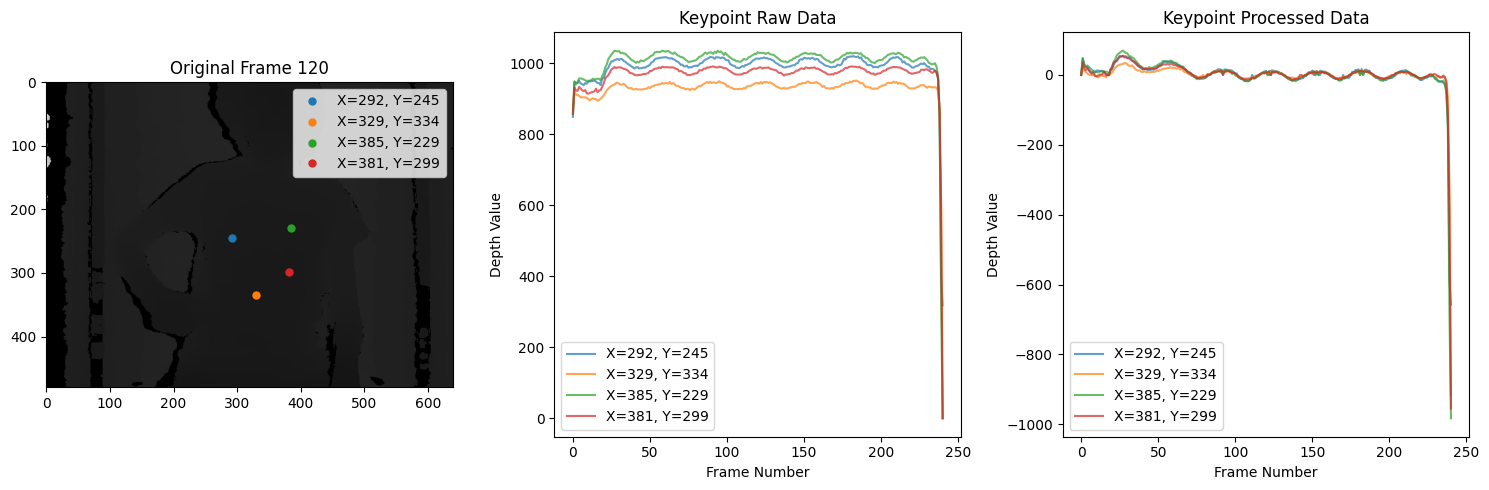

In [93]:
# Define keypoints and process depth files

folder = "C:/Users/LMAPA/Documents/GitHub/vision-black-tech/"

key_points = [(292, 245), (329, 334), (385, 229), (381, 299)]
depth_file = "UniMelb Breath Sensing Project/Depth Camera Breathing Datasets/Relaxed Exaggerated Breathing/depthOutput.tiff"
data_loader = TiffReader(folder + depth_file)
process_depth_frames(data_loader, key_points)


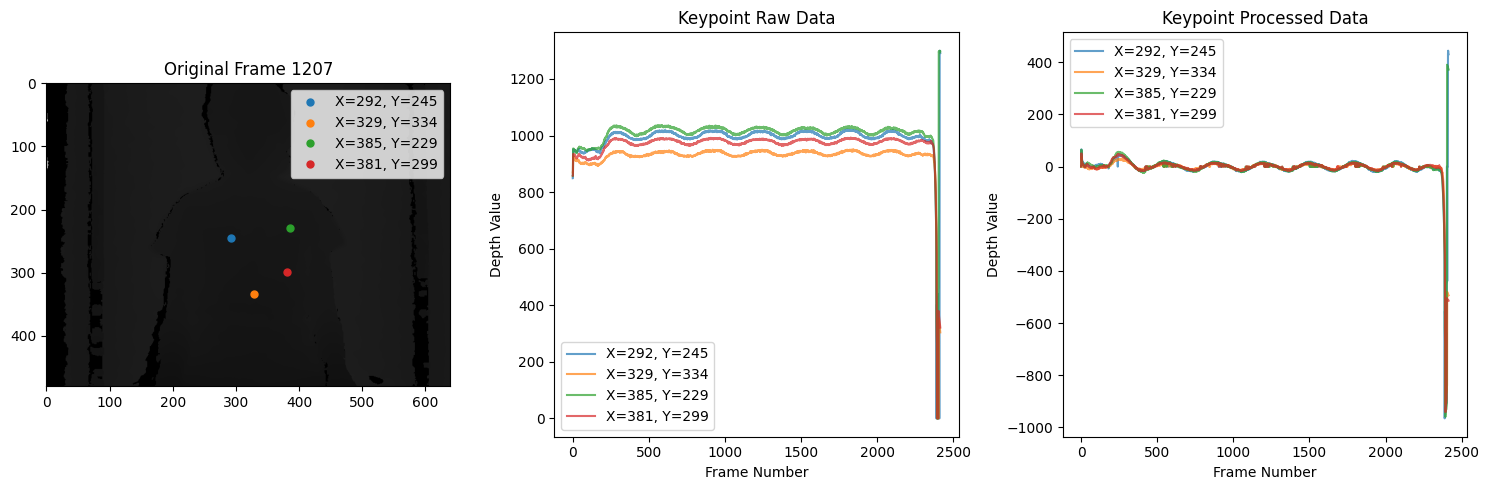

In [94]:
process_depth_frames(data_loader, key_points, window_size=5, batch_size=2, fps=30)

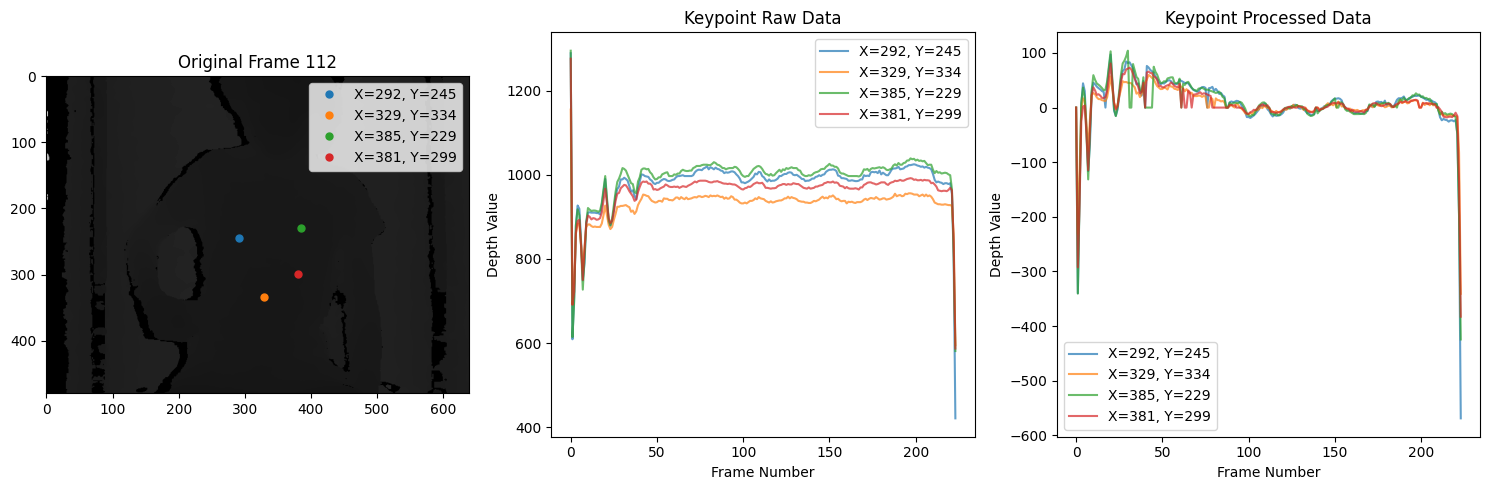

In [95]:
depth_file = "UniMelb Breath Sensing Project/Depth Camera Breathing Datasets/Fidgeting Tidal Breathing/depthOutput.tiff"
data_loader = TiffReader(folder + depth_file)
process_depth_frames(data_loader, key_points)


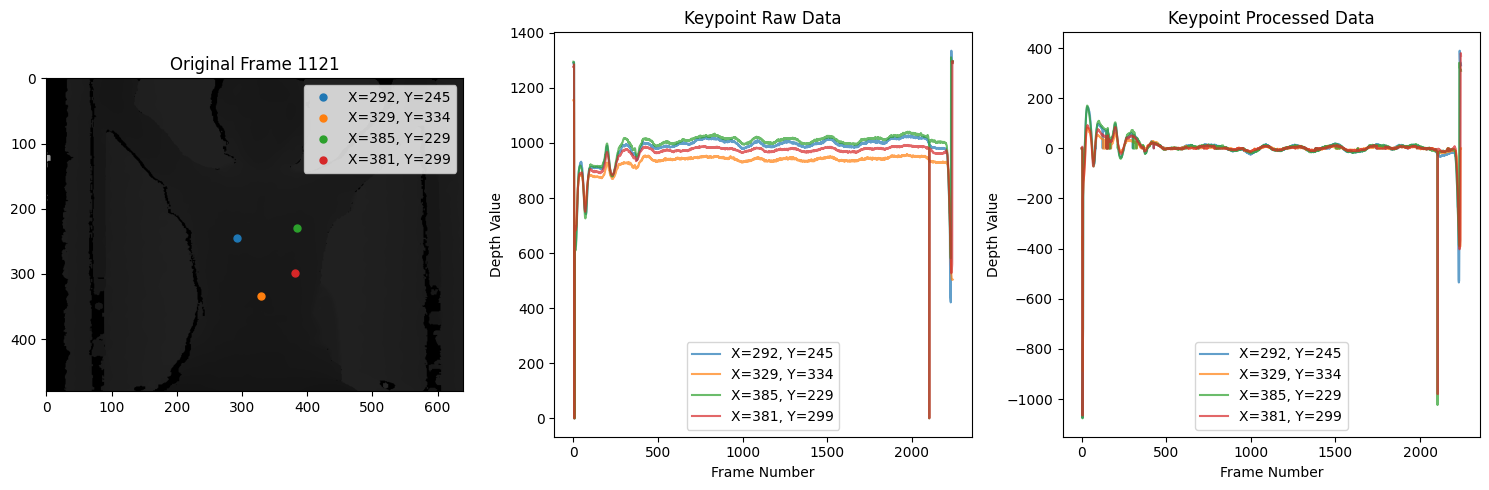

In [96]:
process_depth_frames(data_loader, key_points, window_size=5, batch_size=2, fps=30)

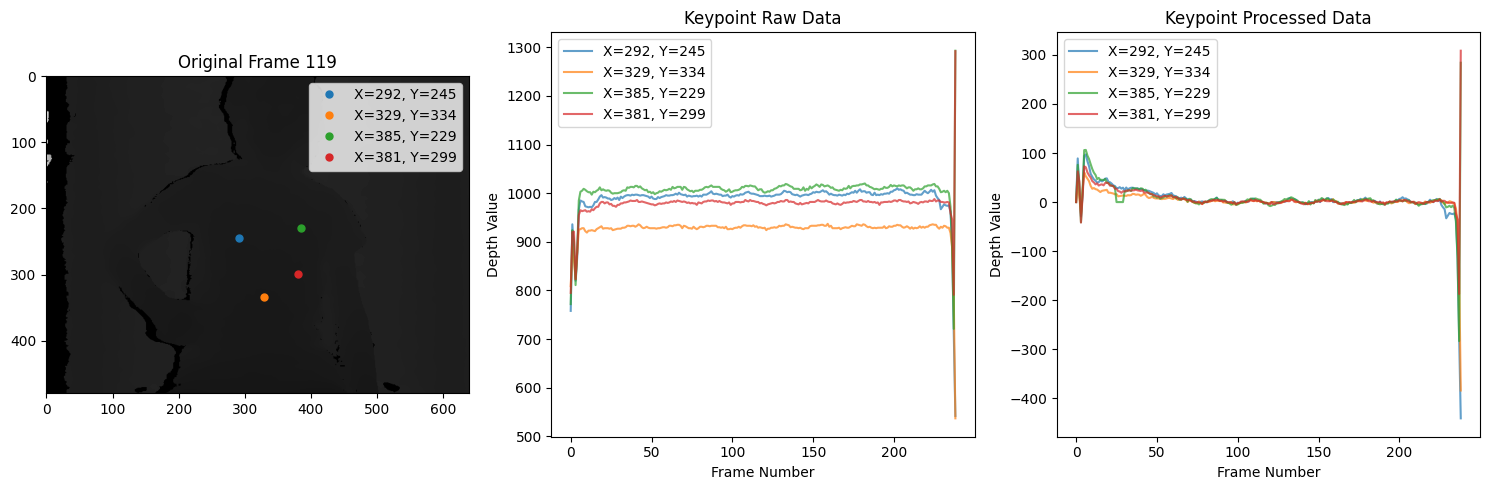

In [97]:
depth_file = "UniMelb Breath Sensing Project/Depth Camera Breathing Datasets/Control - Relaxed Tidal Breathing/depthOutput.tiff"
data_loader = TiffReader(folder + depth_file)
process_depth_frames(data_loader, key_points)


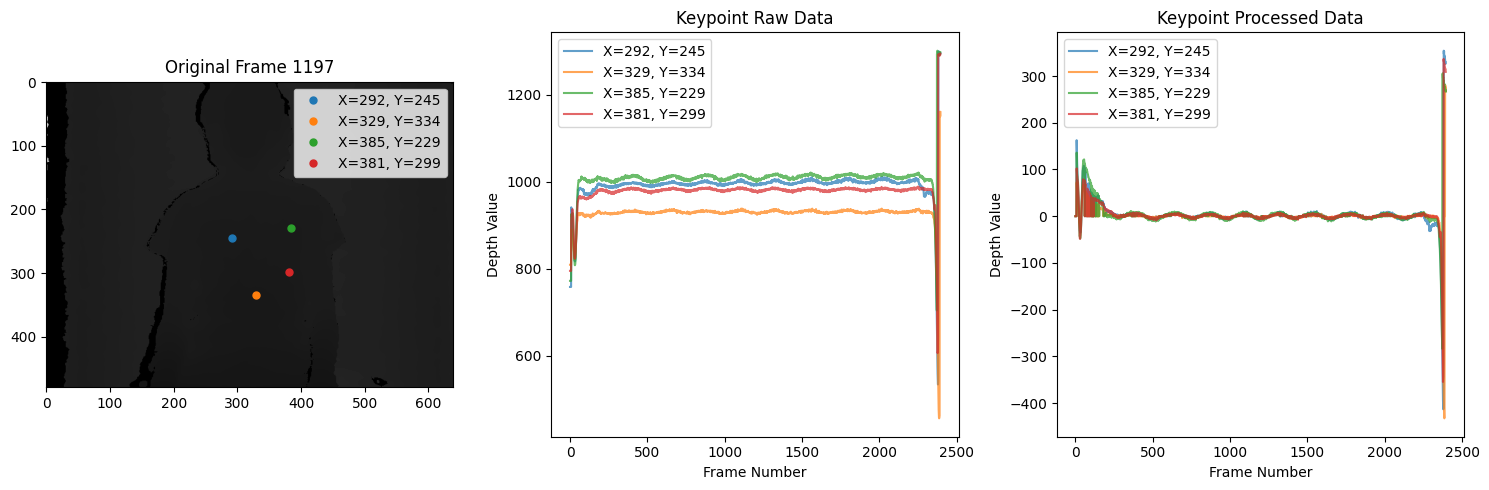

In [98]:
process_depth_frames(data_loader, key_points, window_size=5, batch_size=2, fps=30)

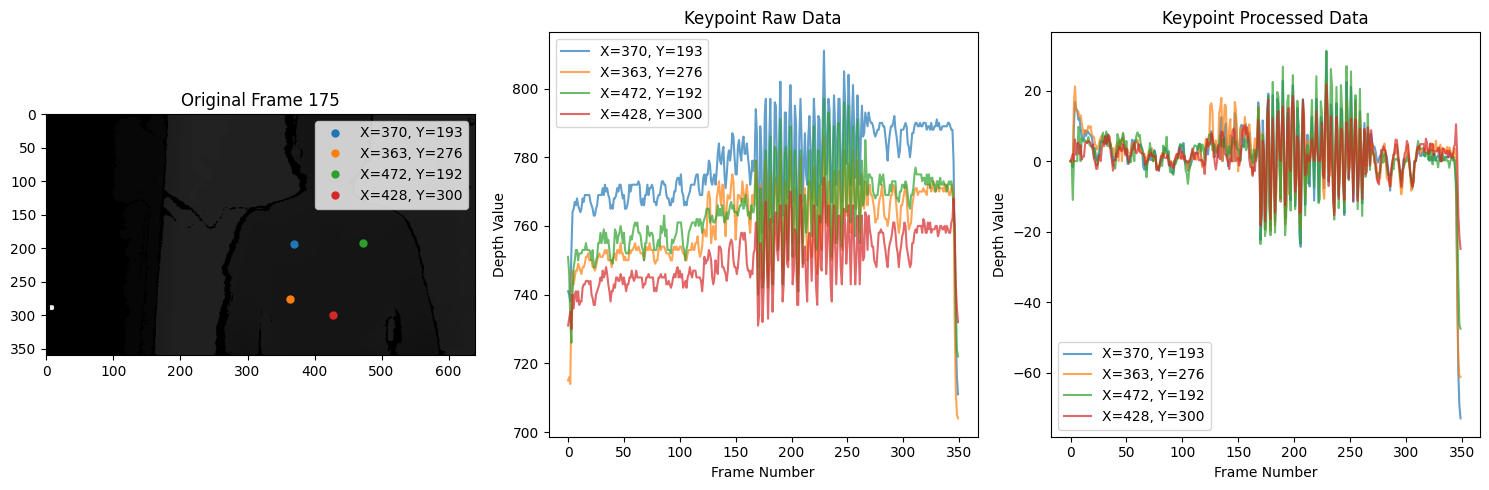

In [99]:
key_points = [(370, 193), (363, 276), (472, 192), (428, 300)]
depth_file = "rs_data/20250319_111903_depth_frames.tiff"
data_loader = TiffReader(folder + depth_file)
process_depth_frames(data_loader, key_points)


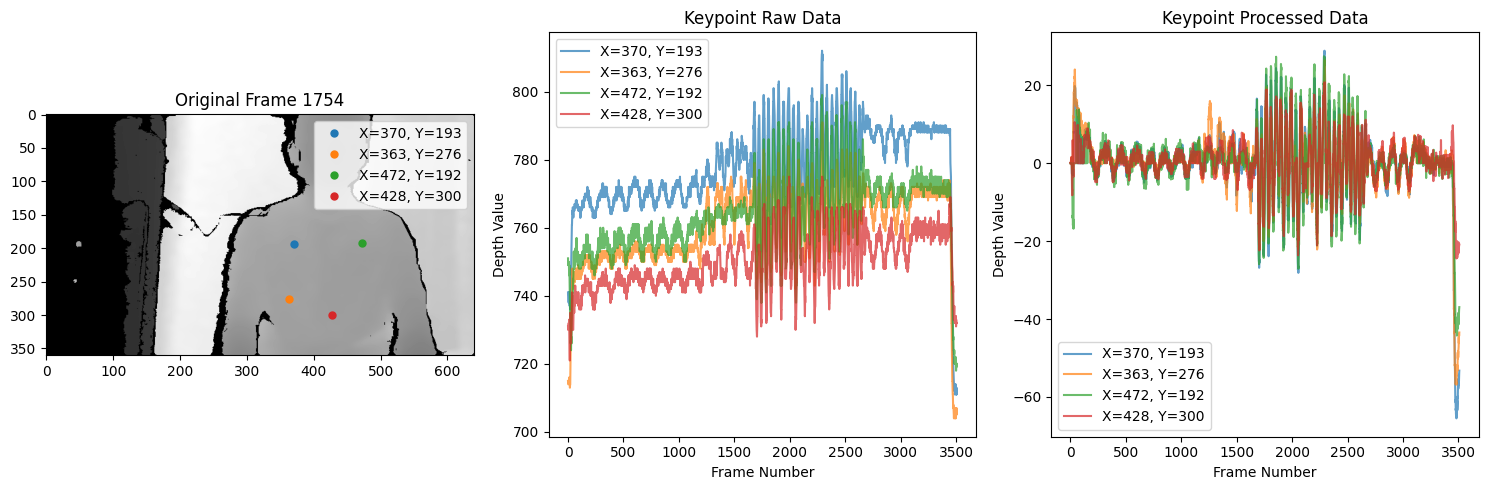

In [100]:
process_depth_frames(data_loader, key_points, window_size=5, batch_size=2, fps=30)

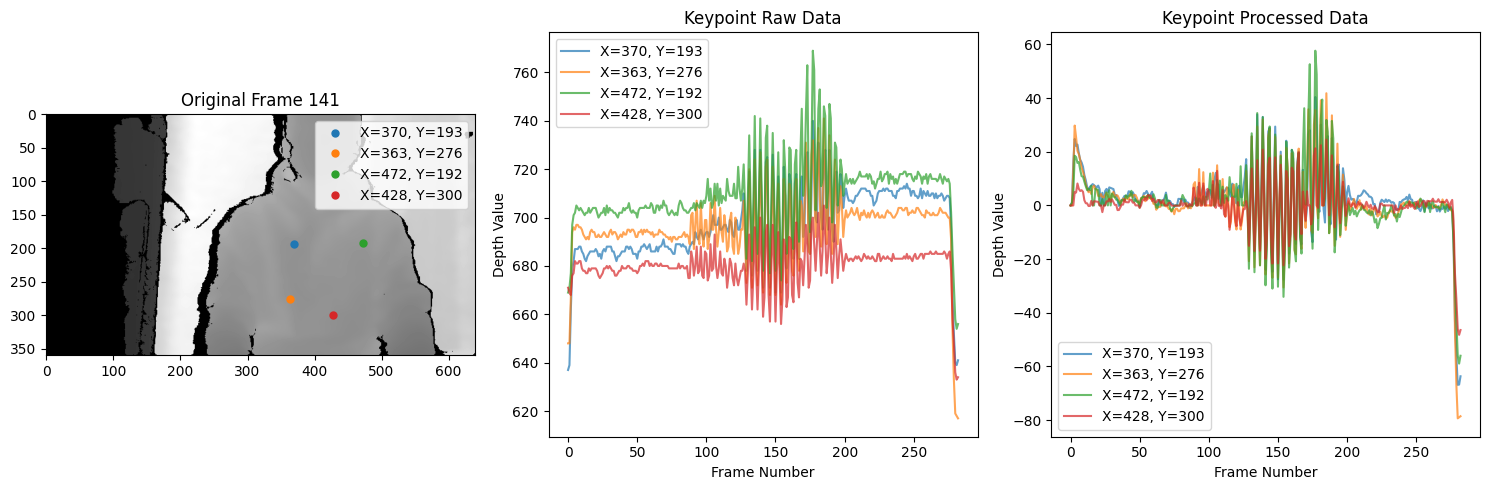

In [101]:
depth_file = "rs_data/20250319_112130_depth_frames.tiff"
data_loader = TiffReader(folder + depth_file)
process_depth_frames(data_loader, key_points)


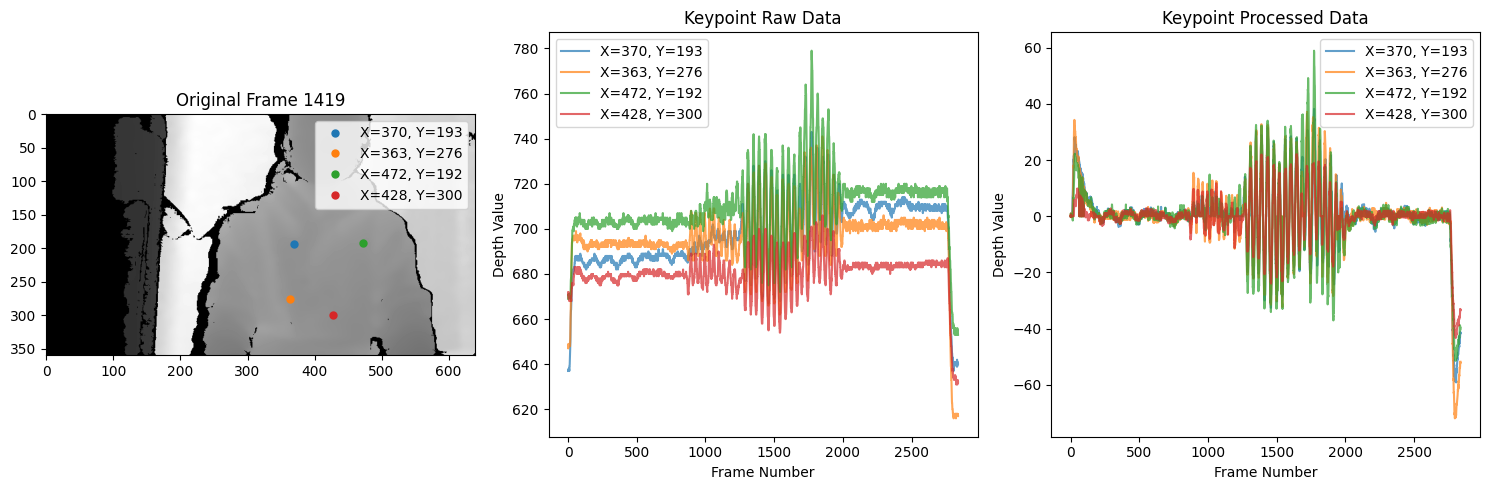

In [102]:
process_depth_frames(data_loader, key_points, window_size=5, batch_size=2, fps=30)

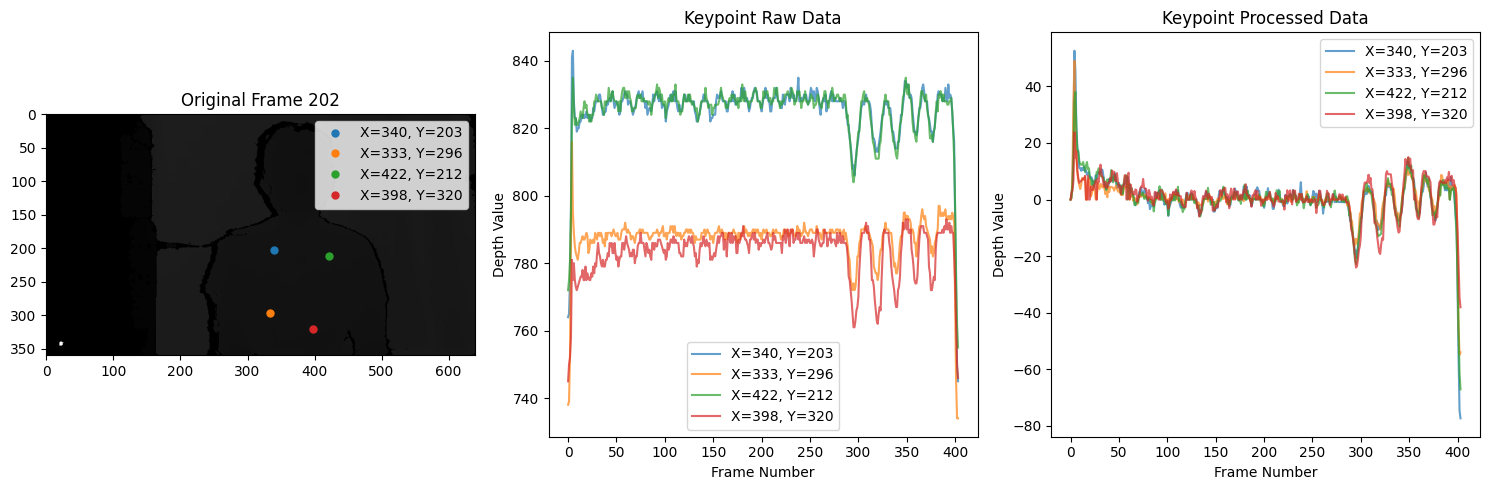

In [103]:
key_points = [(340, 203), (333, 296), (422, 212), (398, 320)]
depth_file = "rs_data/20250320_150946_depth_frames.tiff"
data_loader = TiffReader(folder + depth_file)
# plot_depth_map(data_loader, key_points)
process_depth_frames(data_loader, key_points)


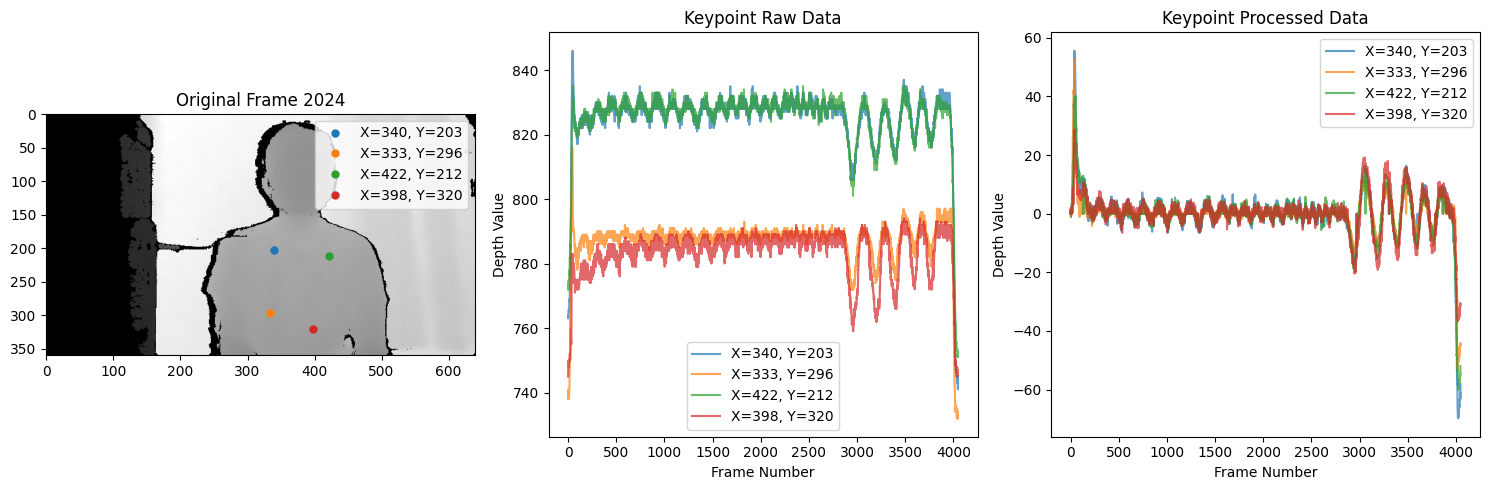

In [104]:
process_depth_frames(data_loader, key_points, window_size=5, batch_size=2, fps=30)

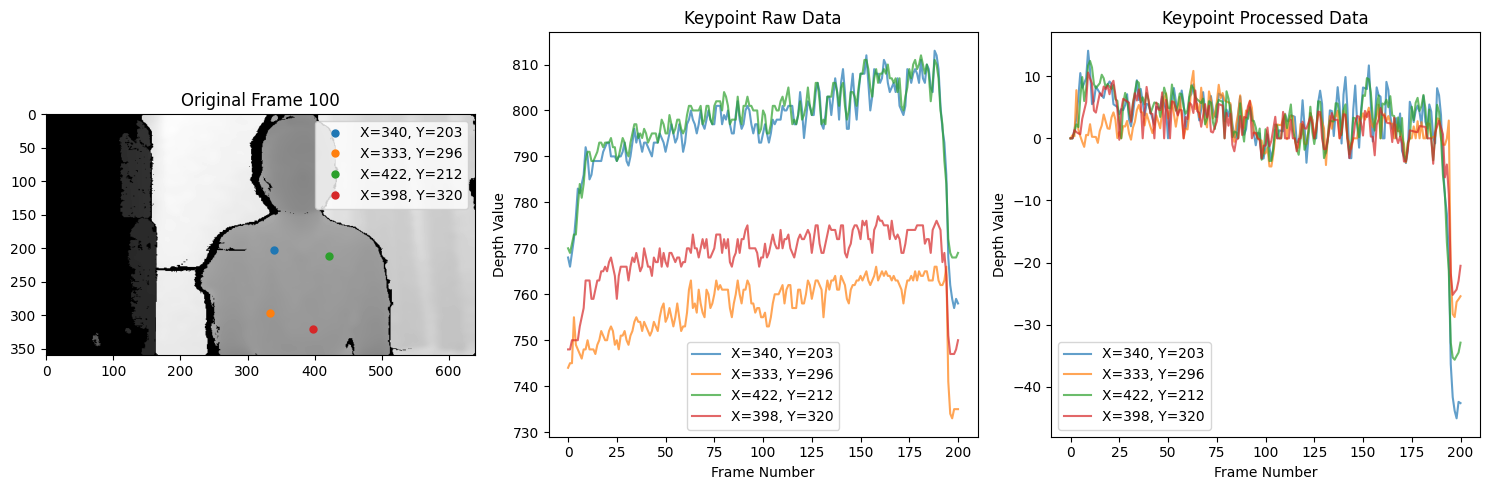

In [105]:
depth_file = "rs_data/20250320_151150_depth_frames.tiff"
data_loader = TiffReader(folder + depth_file)
process_depth_frames(data_loader, key_points)

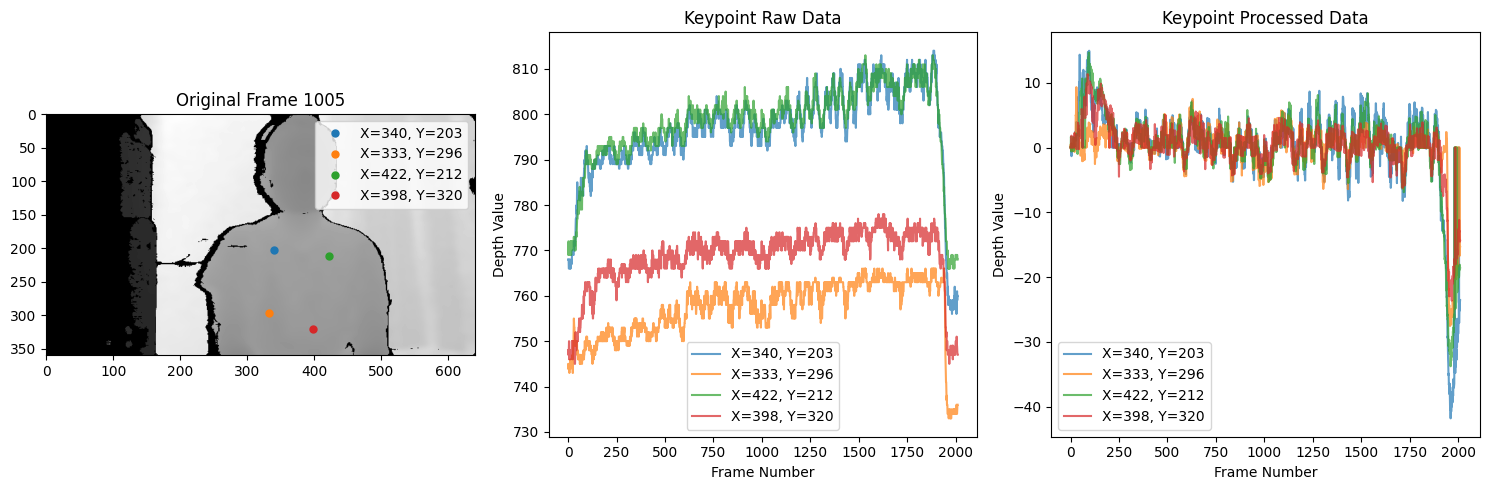

In [106]:
process_depth_frames(data_loader, key_points, window_size=5, batch_size=2, fps=30)

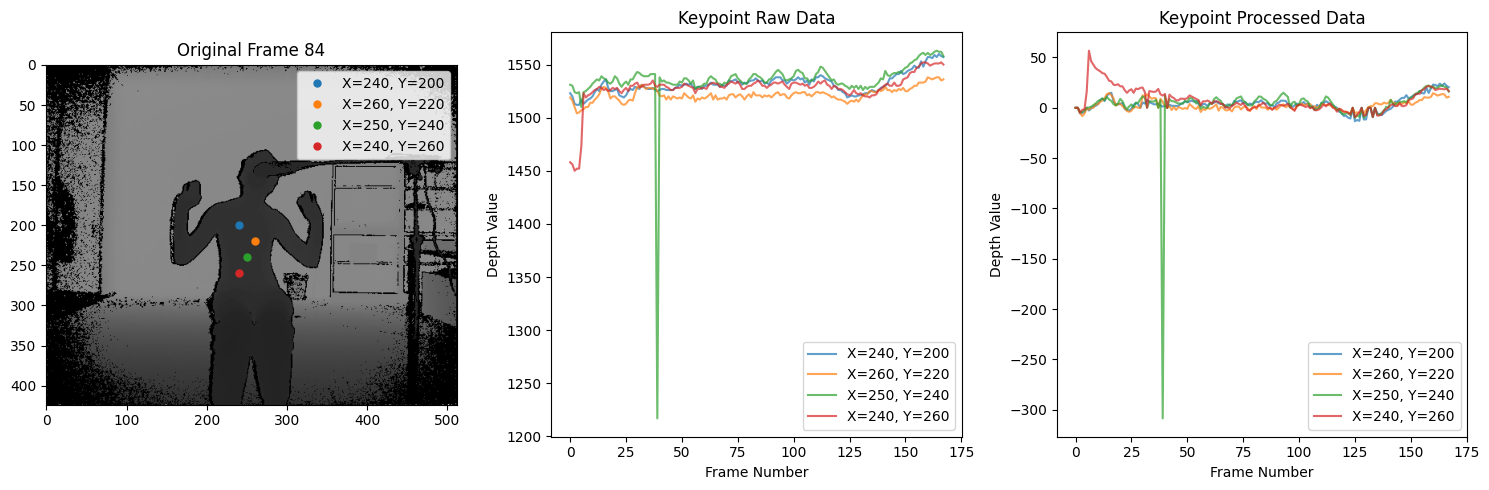

In [107]:
key_points = [(240, 200), (260, 220), (250, 240), (240, 260)]
folder = "D:/1tqzx39mzkw832msuvy3obktqi/subject_10/83/data_fKinect/depth_frames"
data_loader = PngReader(folder)
# plot_depth_map(data_loader, key_points)
process_depth_frames(data_loader, key_points)

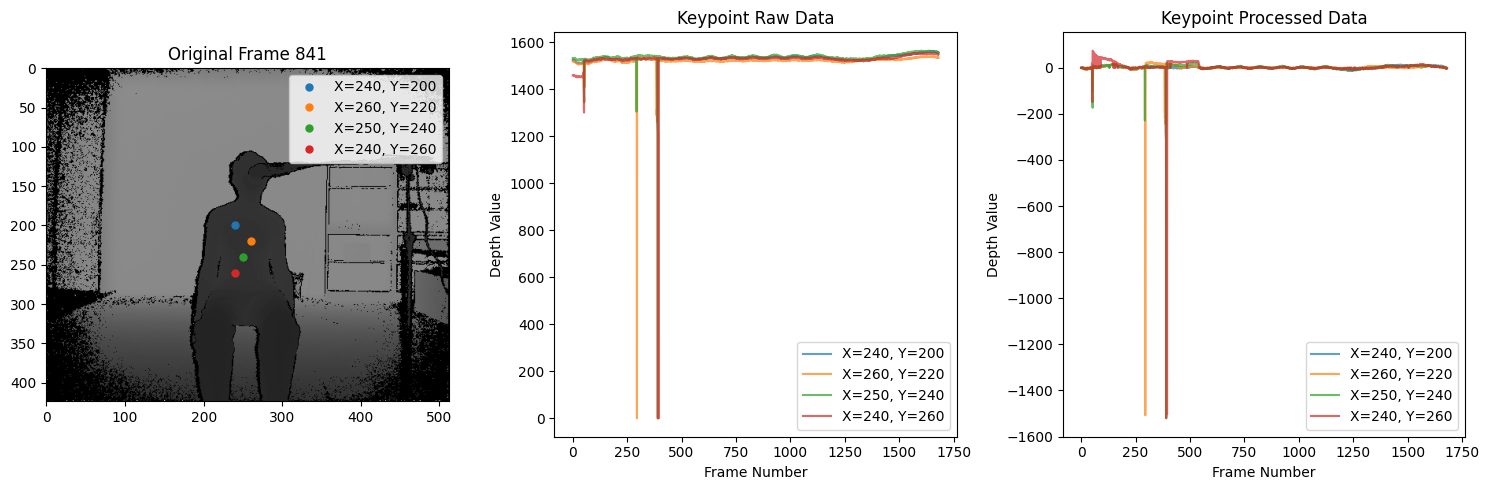

In [108]:
process_depth_frames(data_loader, key_points, window_size=5, batch_size=2, fps=30)

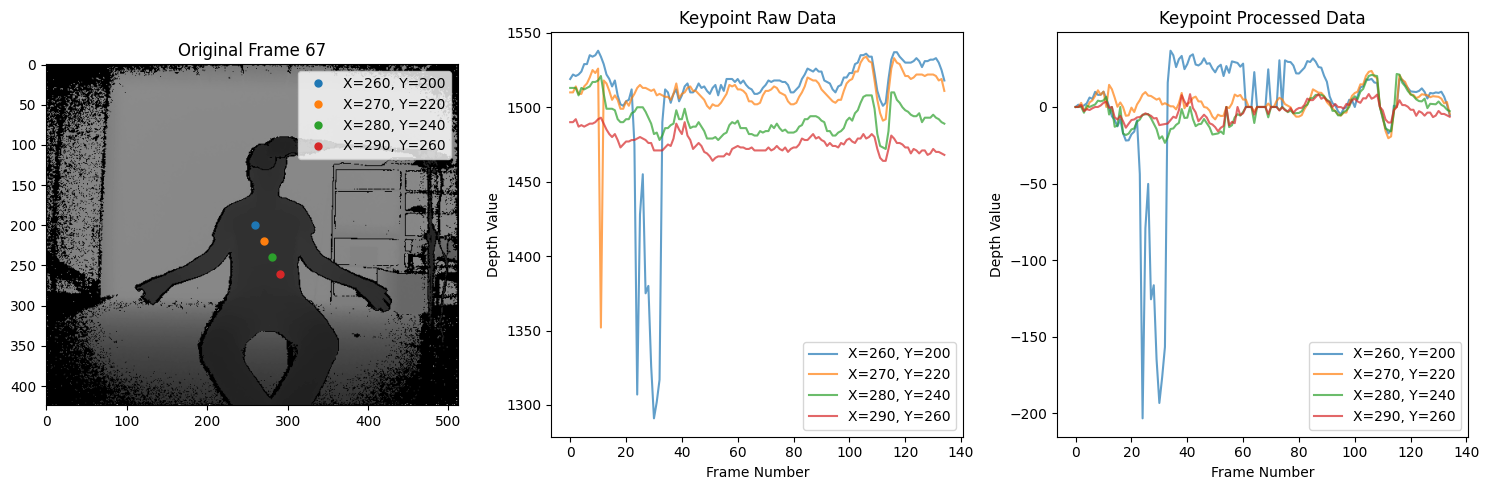

In [109]:
key_points = [(260, 200), (270, 220), (280, 240), (290, 260)]
folder = "D:/1tqzx39mzkw832msuvy3obktqi/subject_26/228/data_fKinect/depth_frames"
data_loader = PngReader(folder)
# plot_depth_map(data_loader, key_points)
process_depth_frames(data_loader, key_points)

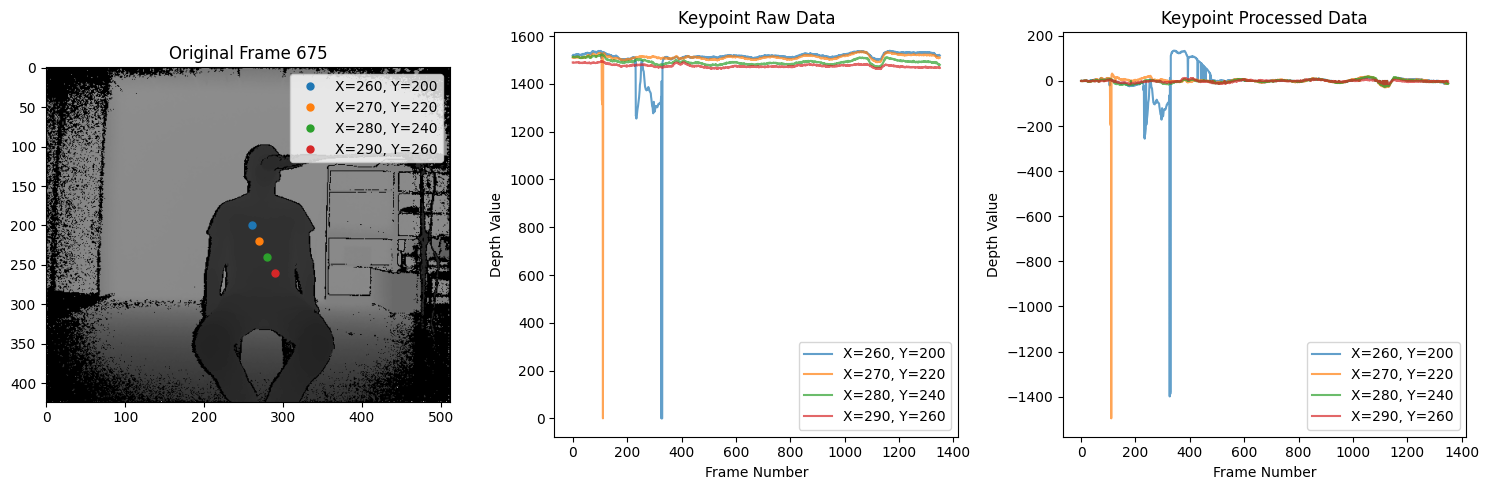

In [110]:
process_depth_frames(data_loader, key_points, window_size=5, batch_size=2, fps=30)

# Test with segmentator

In [111]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from collections import OrderedDict
import time

class Segmentator(nn.Module):
    def __init__(self):
        super(Segmentator, self).__init__()

        # Initial convolutional layers
        self.initial = nn.Sequential(
            nn.Conv2d(1, 64, 7, 2, 3, bias=False),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )

        # Load pre-trained ResNet-18 on IMAgeNet
        weights = ResNet18_Weights.IMAGENET1K_V1
        model = resnet18(weights=weights)

        # Downsampling layers
        self.down1 = nn.Sequential(OrderedDict([('1', model.layer1)]))
        self.down2 = model.layer2

        # Upsampling layers
        self.up1 = nn.Sequential(OrderedDict([
            ('up_conv', nn.ConvTranspose2d(128, 128, 2, 2, 0)),
            ('bn', nn.BatchNorm2d(128)),
            ('relu', nn.ReLU()),
            ('drop', nn.Dropout(0.5))  # Add Dropout
        ]))

        self.up0 = nn.Sequential(OrderedDict([
            ('up_conv', nn.ConvTranspose2d(128, 64, 2, 2, 0)),
            ('bn', nn.BatchNorm2d(64)),
            ('relu', nn.ReLU()),
            ('drop', nn.Dropout(0.5))  # Add Dropout
        ]))

        # Final upsampling and convolutional layers
        self.final_upsample = nn.Sequential(OrderedDict([
            ('1', nn.Conv2d(64, 32, 3, 1, 1, bias=False)),
            ('2', nn.Conv2d(32, 64, 3, 1, 1, bias=False)),
        ]))

        self.final_conv = nn.Conv2d(64, 1, 1, 1, 0)

    def forward(self, x):
        start_time = time.time()  # Record the start time

        # print("Input shape:", x.shape)

        x = self.initial(x)
        # print("Initial convolution output shape:", x.shape)

        x = self.down1(x)
        # print("Downsampling block 1 output shape:", x.shape)

        x = self.down2(x)
        # print("Downsampling block 2 output shape:", x.shape)

        x = self.up1(x)
        # print("Upsampling block 1 output shape:", x.shape)

        x = self.up0(x)
        # print("Upsampling block 2 output shape:", x.shape)

        x = self.final_upsample(x)
        # print("Final upsampling output shape:", x.shape)

        x = self.final_conv(x)
        # print("Final convolution output shape:", x.shape)

        end_time = time.time()  # Record the end time
        # print(f"Total inference time: {end_time - start_time:.4f} seconds")  # Print the total inference time

        return x


In [112]:
import torch

def read_model_state(data, output_file):
    # Attempt to load the PyTorch model file
    try:
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write(f"Data type: {type(data)}\n")
            
            # If the data is a dictionary, check its keys
            if isinstance(data, dict):
                f.write(f"Dictionary keys: {list(data.keys())}\n")
                
                # If it contains a state_dict, infer the model structure
                if "state_dict" in data or isinstance(data, dict):
                    f.write("This might be the state_dict of a model.\n")
                    # Example: Print part of the state_dict content
                    for key, value in data.items():
                        shape = value.shape if hasattr(value, 'shape') else 'Unknown'
                        f.write(f"Weight name: {key}, Weight shape: {shape}\n")
            else:
                f.write(f"File content: {data}\n")
    except Exception as e:
        with open(output_file, 'a', encoding='utf-8') as f:
            f.write(f"Failed to read the file: {e}\n")

# Example: Read a PyTorch model file
file_path = "segmentator.pkl"
output_path = "model_deepbreath.txt"

# Load the model file
try:
    with open(file_path, 'rb') as f:
        data = torch.load(f, map_location="cpu")
        read_model_state(data, output_path)
    print(f"Output has been saved to: {output_path}")
except Exception as e:
    print(f"Failed to load the model file: {e}")


Output has been saved to: model_deepbreath.txt


C:\Users\LMAPA\AppData\Local\Temp\ipykernel_30932\631337330.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(f, map_location="cpu")


In [113]:
# Instantiate the model
model = Segmentator()

# Save the model's state_dict to a file for inspection
read_model_state(model.state_dict(), "model_test.txt")

# Load the weights
file_path = "segmentator.pkl"
state_dict = torch.load(file_path, map_location="cpu")
model.load_state_dict(state_dict, strict=True)

print("Model loaded successfully!")


Model loaded successfully!


C:\Users\LMAPA\AppData\Local\Temp\ipykernel_30932\767712861.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(file_path, map_location="cpu")


In [114]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

Segmentator(
  (initial): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down1): Sequential(
    (1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [115]:
def process_segmentator(depth_map, threshold):
    
    # Normalize the depth map to [0, 1]
    # normalized_depth_map = depth_map / np.max(depth_map)
    # Normalize the depth map to [-1, 1]
    normalized_depth_map = 2 * (depth_map - np.min(depth_map)) / (np.max(depth_map) - np.min(depth_map)) - 1

    input_tensor = torch.tensor(normalized_depth_map, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    # Pass the tensor through the model
    with torch.no_grad():  # Disable gradient computation
        output = model(input_tensor)
        output_np = output.squeeze().numpy()

    # Binarize the output to create a mask (values 0 or 1)
    binary_mask = (output_np > threshold).astype(np.uint8)  # Values greater than the threshold are set to 1, others to 0

    # Resize the binary mask to MAtch the original depth map size
    binary_mask_resized = cv2.resize(binary_mask, (depth_map.shape[1], depth_map.shape[0]), interpolation=cv2.INTER_NEAREST)

    return binary_mask_resized

In [118]:
def process_mac_with_segmentator(data_loader, key_points, threshold, window_size=20, batch_size=5, fps=3):
    """
    Process depth frames from a TIFF file and visualize keypoint data.
    """
    default_fps = 30
    drop_rate = default_fps // fps
    num_frames = data_loader.len() // drop_rate

    # Initialize the artifact remover
    artifact_remover = MotionArtifactRemover(window_size=window_size, batch_size=batch_size, alpha=20, fps=fps)

    # Initialize lists for keypoint data
    key_data_raw = [[] for _ in range(len(key_points))]
    key_data_processed = [[] for _ in range(len(key_points))]

    # Initialize the output videos
    folder = "output_videos"
    os.makedirs(folder, exist_ok=True)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    o1 = cv2.VideoWriter(os.path.join(folder, '1-original.avi'), fourcc, fps, (128, 128), isColor=False)
    o2 = cv2.VideoWriter(os.path.join(folder, '2-segmentator_mask.avi'), fourcc, fps, (128, 128), isColor=False)
    o3 = cv2.VideoWriter(os.path.join(folder, '3-masked_frame.avi'), fourcc, fps, (128, 128), isColor=False)
    o4 = cv2.VideoWriter(os.path.join(folder, '4-flag_frame.avi'), fourcc, fps, (128, 128), isColor=False)
    o5 = cv2.VideoWriter(os.path.join(folder, '5-motion_average_frame.avi'), fourcc, fps, (128, 128), isColor=False)
    o6 = cv2.VideoWriter(os.path.join(folder, '6-processed_frame.avi'), fourcc, fps, (128, 128), isColor=False)


    # Process each frame in the TIFF file
    for i in range(num_frames):
        frame = data_loader.read_image(i)

        
        frame = cv2.resize(frame, (128, 128), interpolation=cv2.INTER_LINEAR)
        original_frame = frame.copy()  # Keep a copy of the original frame for display
        o1.write(original_frame.astype('uint8'))  # Write the original frame to video

        binary_mask_resized = process_segmentator(frame, threshold)
        cv2.imshow('Segmentator Binary Mask', (binary_mask_resized * 255).astype('uint8'))  # Display the binary mask
        o2.write((binary_mask_resized * 255).astype('uint8'))  # Write the binary mask to video

        frame = np.where(binary_mask_resized == 1, frame, 0)  # Apply the mask to the frame
        cv2.imshow('Masked Frame', frame.astype('uint8'))  # Display the masked frame
        o3.write(frame.astype('uint8'))  # Write the masked frame to video

        # Process the frame
        processed_frame, flag, ma = artifact_remover.process_frame(frame)

        # Store keypoint data
        for j, (x, y) in enumerate(key_points):
            if i < num_frames:
                key_data_raw[j].append(frame[y, x])  # Store raw keypoint data
                key_data_processed[j].append(processed_frame[y, x])  # Store processed keypoint data

        # Display original and processed frames
        cv2.imshow('Original Frame', frame.astype('uint8'))

        if flag is not None and ma is not None:
            cv2.imshow('Flag Frame', (flag * 255).astype('uint8'))
            o4.write((flag * 255).astype('uint8'))
            cv2.imshow('MA Frame', ma.astype('uint8'))
            o5.write(ma.astype('uint8'))  # Write the MA frame to video


        cv2.imshow('Processed Frame', processed_frame.astype('uint8'))
        o6.write(processed_frame.astype('uint8'))  # Write the processed frame to video

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        if i == num_frames // 2:  # Display the middle frame
            # Display all frames in one window with a grid layout
            plt.figure(figsize=(15, 10))

            # Original Frame
            plt.subplot(2, 3, 1)
            plt.imshow(original_frame.astype('uint8'), cmap='gray')
            plt.title('1. Original Frame')
            plt.axis('off')

            # 2. Segmentator Binary Mask
            plt.subplot(2, 3, 2)
            plt.imshow((binary_mask_resized * 255).astype('uint8'), cmap='gray')
            plt.title('2. Segmentator Binary Mask')
            plt.axis('off')

            # masked Frame
            plt.subplot(2, 3, 3)
            plt.imshow(frame.astype('uint8'), cmap='gray')
            plt.title('3. Masked Frame')
            plt.axis('off')

            # Flag Frame
            if flag is not None:
                plt.subplot(2, 3, 4)
                plt.imshow((flag * 255).astype('uint8'), cmap='gray')
                plt.title('4. Flag Frame')
                plt.axis('off')

            # MA Frame
            if ma is not None:
                plt.subplot(2, 3, 5)
                plt.imshow(ma.astype('uint8'), cmap='gray')
                plt.title('5. Average Frame')
                plt.axis('off')

            # Processed Frame
            plt.subplot(2, 3, 6)
            plt.imshow(processed_frame.astype('uint8'), cmap='gray')
            plt.title('6. Subtracted Frame')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

    # Release resources
    cv2.destroyAllWindows()

    # Plot keypoint data
    i = num_frames // 2
    example_frame = data_loader.read_image(i)
    example_frame = cv2.resize(example_frame, (128, 128), interpolation=cv2.INTER_LINEAR)


    plt.figure(figsize=(15, 5))

    # Plot original frame with keypoints
    plt.subplot(1, 3, 1)
    plt.imshow(example_frame, cmap='gray')
    for j in range(len(key_points)):
        plt.plot(key_points[j][0], key_points[j][1], 'o', markersize=5, label=f'X={key_points[j][0]}, Y={key_points[j][1]}')
    plt.title(f'Original Frame {i}')
    plt.legend()

    # Plot raw keypoint data
    plt.subplot(1, 3, 2)
    for j in range(len(key_points)):
        plt.plot(key_data_raw[j], label=f'X={key_points[j][0]}, Y={key_points[j][1]}', alpha=0.7)
    plt.title('Keypoint Raw Data')
    plt.xlabel('Frame Number')
    plt.ylabel('Depth Value')
    plt.legend()

    # Plot processed keypoint data
    plt.subplot(1, 3, 3)
    for j in range(len(key_points)):
        plt.plot(key_data_processed[j], label=f'X={key_points[j][0]}, Y={key_points[j][1]}', alpha=0.7)
    plt.title('Keypoint Processed Data')
    plt.xlabel('Frame Number')
    plt.ylabel('Depth Value')
    plt.legend()

    plt.tight_layout()
    plt.show()


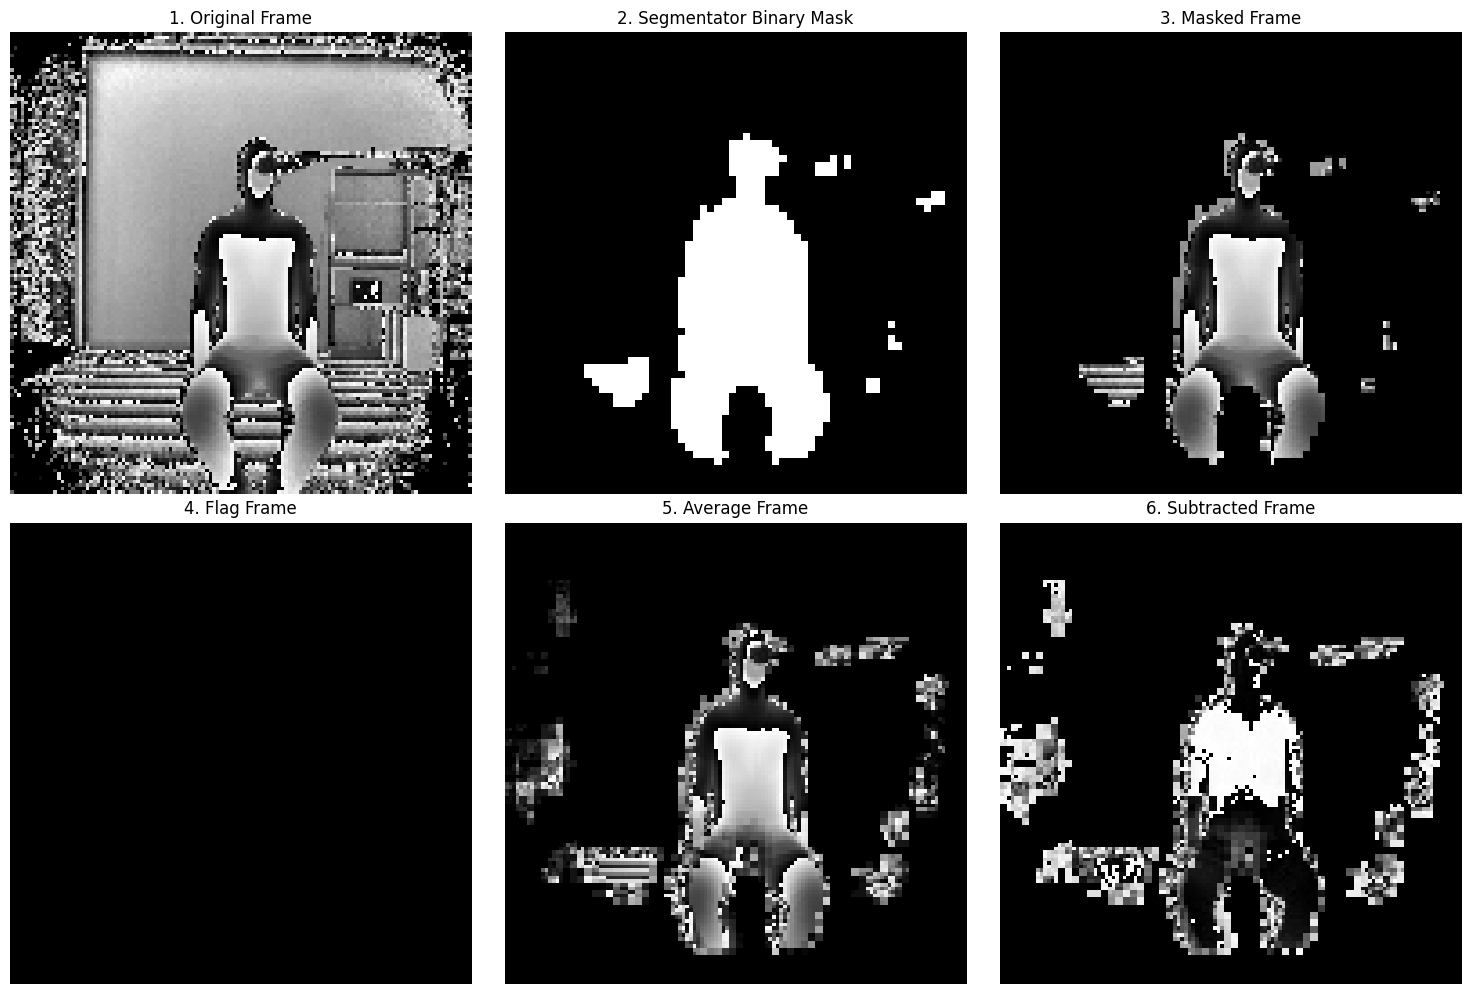

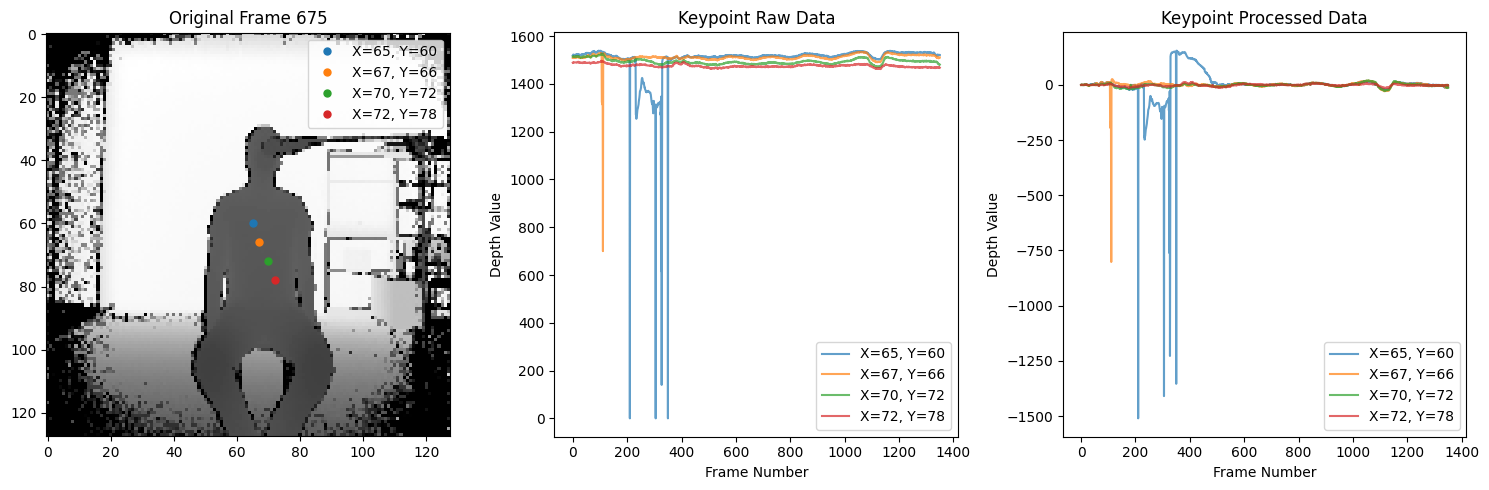

In [121]:
x_scale = 128/512
y_scale = 128/424
key_points = [(260, 200), (270, 220), (280, 240), (290, 260)]
key_points = [(int(x * x_scale), int(y * y_scale)) for x, y in key_points]
folder = "D:/1tqzx39mzkw832msuvy3obktqi/subject_26/228/data_fKinect/depth_frames"
data_loader = PngReader(folder)
process_mac_with_segmentator(data_loader, key_points, threshold=0, window_size=5, batch_size=2, fps=30)